In [1]:
import bmxdata
import numpy as np
from numpy.fft import rfft, irfft
import matplotlib.pyplot as plt
import gc
from scipy.optimize import leastsq

%matplotlib inline

In [2]:
da=bmxdata.BMXRingbuffer('/astro/u/anze/data/longbmx/190411_130707_D1.ring')

Loading version: 1
Ncards: 2 Size: 2147483648


In [52]:
fftcache={}

In [113]:
def getPS (self, stream='datad0c1',fftpow=25, numin=1419.00, numax=1422.50, fftavg=512, 
                   ndxmin=0, ndxmax=-1, rate=1.1e3, indices=False,killspikes=False, killavg=256,killfact=8, killbuf=50):
            data=getattr(self,stream)
            fftsize=2**fftpow
            numin_,numax_=numin,numax
            nunyq=rate/2;
            dnu=nunyq/(fftsize/2+1);
            if ndxmax<=0:
                ndxmax=len(data)//fftsize
            while (abs(numin)>nunyq): numin=numin-rate
            while (abs(numax)>nunyq): numax=numax-rate
            numin=abs(numin);
            numax=abs(numax);
            if (numax<numin): numin,numax=numax,numin
            print ("   Frequencies %f - %f Mhz appear as %f - %f \n"%(numin_,numax_,numin,numax))
            imin=int(numin/dnu)
            if (imin==0): imin=1;
            imax=int(numax/dnu)
            pssize1=(imax-imin)//fftavg
            if ((imax-imin)%fftavg>0): pssize1+=1;
            imax=imin+pssize1*fftavg
            freq=np.arange(imin+fftavg/2,imax,fftavg)*dnu+rate
            out=[]
            
            for istart in range(ndxmin,ndxmax):
                print ("%i/%i..."%(istart,(ndxmax-ndxmin)),end="")
                cachekey=(fftpow,istart)
                if cachekey not in fftcache:
                    fftcache[cachekey]=rfft(data[istart*fftsize:(istart+1)*fftsize])
                fft=fftcache[cachekey]
                ps=abs(fft[imin:imax]**2)
                del fft
                gc.collect()
                if (killspikes>0):
                    yts=ps.reshape((-1,killavg)).mean(axis=1)
                    yts=np.outer(yts,np.ones(len(ps)//len(yts))).flatten()
                    tkill=0
                    for i in np.where(ps>yts*killfact)[0]:
                        #print (i)
                        ps[i-killbuf:i+killbuf+1]=np.nan
                        tkill+=killbuf*2
                    print ("Killed: %i/%i = %f %%"%(tkill,imax-imin,100*tkill/(imax-imin)))
                if fftavg>1:
                    ps=np.nanmean(ps.reshape((-1,fftavg)),axis=1)
                out.append(ps)
                
            out=np.array(out)
            if indices:
                return np.arange(imin,imax), out
            else:
                return freq,out

In [117]:
freq,ps=getPS(da,ndxmax=64,numin=1419.0,numax=1422.0,fftavg=256,killspikes=False)
freqk,psk=getPS(da,ndxmax=64,numin=1419.0,numax=1422.0,fftavg=256,killspikes=True,killbuf=30,killfact=8)

   Frequencies 1419.000000 - 1422.000000 Mhz appear as 319.000000 - 322.000000 

0/64...1/64...2/64...3/64...4/64...5/64...6/64...7/64...8/64...9/64...10/64...11/64...12/64...13/64...14/64...15/64...16/64...17/64...18/64...19/64...20/64...21/64...22/64...23/64...24/64...25/64...26/64...27/64...28/64...29/64...30/64...31/64...32/64...33/64...34/64...35/64...36/64...37/64...38/64...39/64...40/64...41/64...42/64...43/64...44/64...45/64...46/64...47/64...48/64...49/64...50/64...51/64...52/64...53/64...54/64...55/64...56/64...57/64...58/64...59/64...60/64...61/64...62/64...63/64...   Frequencies 1419.000000 - 1422.000000 Mhz appear as 319.000000 - 322.000000 

0/64...Killed: 2760/91648 = 3.011522 %
1/64...Killed: 3420/91648 = 3.731669 %
2/64...Killed: 2940/91648 = 3.207926 %
3/64...Killed: 3240/91648 = 3.535265 %
4/64...Killed: 3240/91648 = 3.535265 %
5/64...Killed: 2760/91648 = 3.011522 %
6/64...Killed: 2940/91648 = 3.207926 %
7/64...Killed: 3600/91648 = 3.928073 %
8/64...Killed: 3600/9164

[]

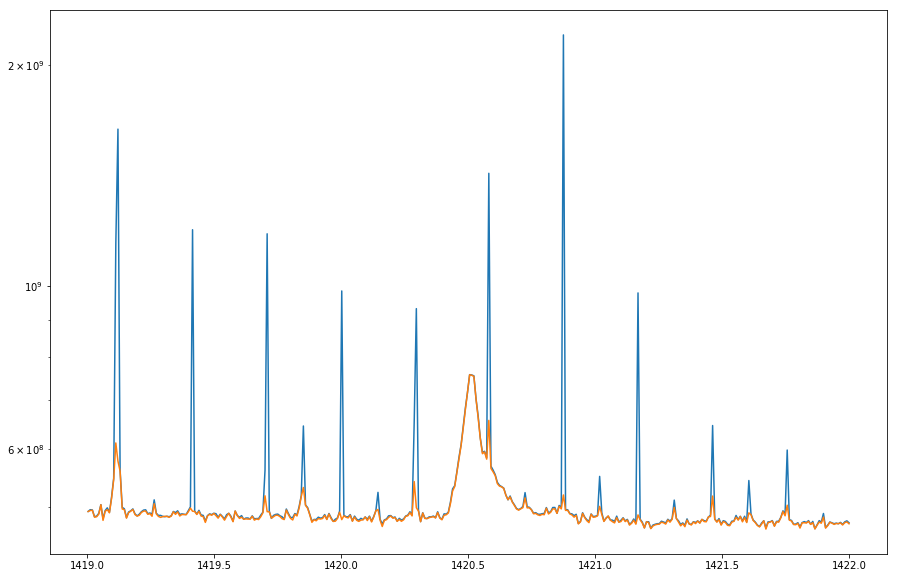

In [118]:
plt.figure(figsize=(15,10))
plt.plot(freq,ps.mean(axis=0))
plt.plot(freqk,psk.mean(axis=0))
plt.semilogy()

   Frequencies 1420.850000 - 1421.000000 Mhz appear as 320.850000 - 321.000000 

0/64...1/64...2/64...3/64...4/64...5/64...6/64...7/64...8/64...9/64...10/64...11/64...12/64...13/64...14/64...15/64...16/64...17/64...18/64...19/64...20/64...21/64...22/64...23/64...24/64...25/64...26/64...27/64...28/64...29/64...30/64...31/64...32/64...33/64...34/64...35/64...36/64...37/64...38/64...39/64...40/64...41/64...42/64...43/64...44/64...45/64...46/64...47/64...48/64...49/64...50/64...51/64...52/64...53/64...54/64...55/64...56/64...57/64...58/64...59/64...60/64...61/64...62/64...63/64...

[]

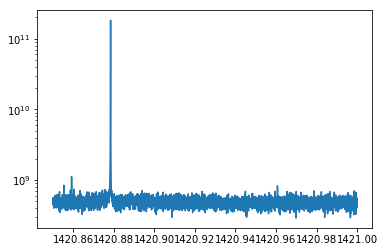

In [119]:
## Let's examine the spike at 1420.8, no averaging
freq,ps=getPS(da,numin=1420.85,numax=1421,fftavg=1,killspikes=False)
psmean=ps.mean(axis=0)
plt.plot(freq,psmean)
plt.semilogy()

[]

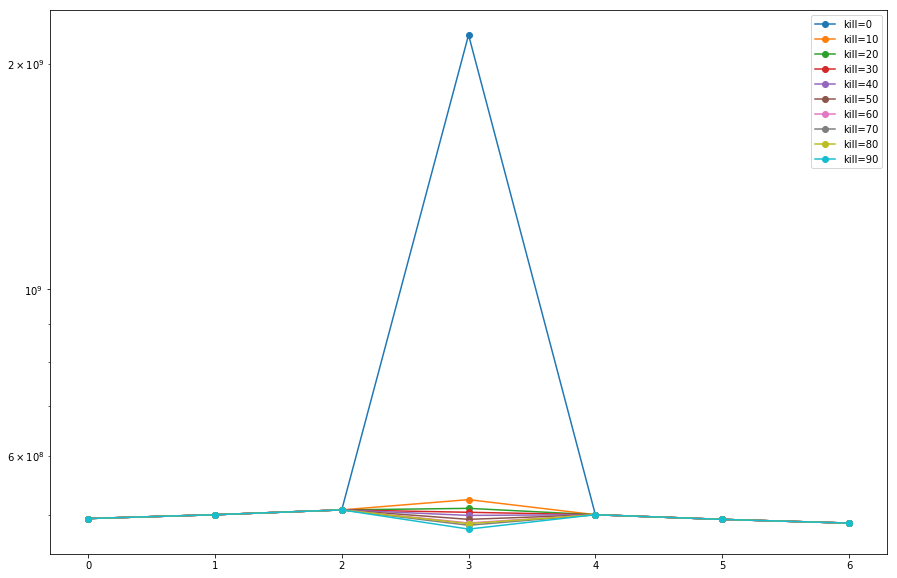

In [123]:
## now try different kills
plt.figure(figsize=(15,10))
ndx=psmean.argmax()
tonan=np.copy(psmean)
for i in range(0,100,10):
    if (i>0):
        tonan[ndx-i:ndx+i+1]=np.nan
    avg=np.nanmean(tonan[:256*7].reshape((-1,256)),axis=1)
    plt.plot (avg, 'o-',label='kill=%i'%i)
plt.legend()
plt.semilogy()